In [ ]:
import pandas as pd

df = pd.read_csv('../data/application_record.csv')


df = df[['CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'AMT_INCOME_TOTAL']].copy()


In [ ]:

credit = pd.read_csv('../data/credit_record.csv')


df = pd.read_csv('../data/application_record.csv')
df = df[['ID', 'CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'AMT_INCOME_TOTAL']]


behavior = credit.groupby('ID')['STATUS'].apply(lambda s: (s.isin(['1', '2', '3', '4', '5']).sum())).reset_index()
behavior.columns = ['ID', 'overdue_months']


df = df.merge(behavior, on='ID', how='left')
df['overdue_months'] = df['overdue_months'].fillna(0)


In [3]:
def behavior_based_approval(row):
    if row['AMT_INCOME_TOTAL'] > 150000 and row['NAME_INCOME_TYPE'] == 'Working' and row['overdue_months'] <= 2:
        return 1
    return 0

df['approved_behavior'] = df.apply(behavior_based_approval, axis=1)


In [5]:
def biased_approval(row):
    bias_flag = 0
    if row['CODE_GENDER'] == 'F':
        bias_flag += 1
    if row['NAME_FAMILY_STATUS'] == 'Single / not married':
        bias_flag += 1
    
    if row['AMT_INCOME_TOTAL'] > 150000 and row['NAME_INCOME_TYPE'] == 'Working' and bias_flag == 0:
        return 1
    return 0


In [ ]:

df['approved_biased'] = df.apply(biased_approval, axis=1)


df['bias_wrong'] = (df['approved_behavior'] == 1) & (df['approved_biased'] == 0)

bias_errors = df[df['bias_wrong'] == True]

print(f"Applicants unfairly rejected due to bias despite good behavior: {len(bias_errors)}")


Applicants unfairly rejected due to bias despite good behavior: 79236


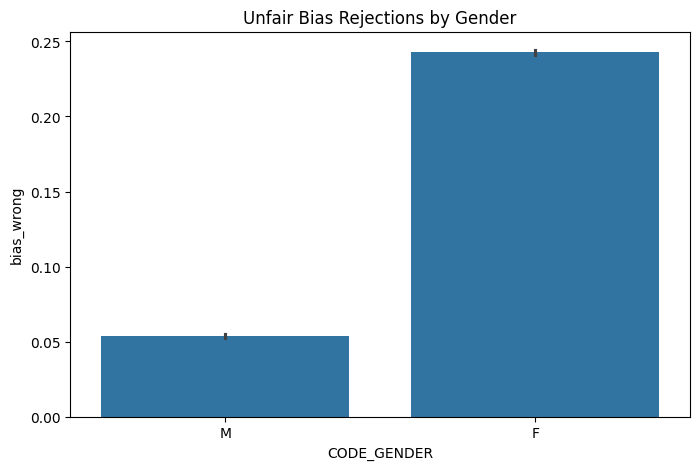

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.barplot(x='CODE_GENDER', y='bias_wrong', data=df)
plt.title("Unfair Bias Rejections by Gender")
plt.show()


In [ ]:

bias_errors.to_csv('../data/unfairly_rejected_cases.csv', index=False)


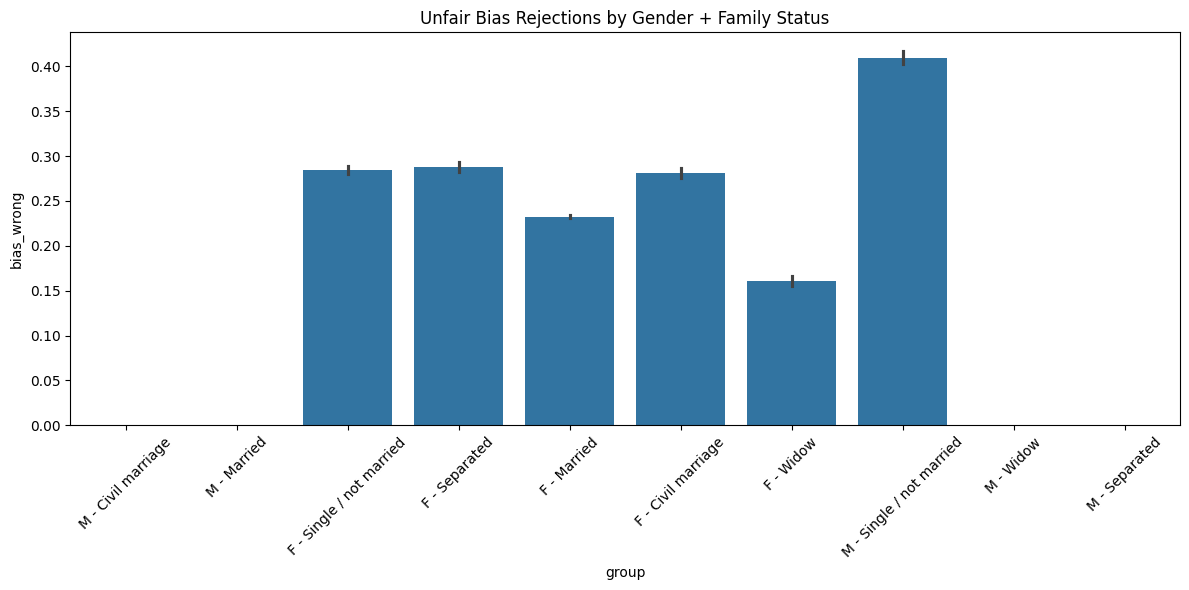

In [9]:
df['group'] = df['CODE_GENDER'] + ' - ' + df['NAME_FAMILY_STATUS']

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(x='group', y='bias_wrong', data=df)
plt.title("Unfair Bias Rejections by Gender + Family Status")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [10]:
def fairer_model(row):
    if row['AMT_INCOME_TOTAL'] > 150000 and row['NAME_INCOME_TYPE'] == 'Working' and row['overdue_months'] <= 2:
        return 1
    return 0

df['approved_fairer'] = df.apply(fairer_model, axis=1)


In [11]:
fair_approval_rate = df['approved_fairer'].mean()
biased_approval_rate = df['approved_biased'].mean()

print(f"Biased Approval Rate: {biased_approval_rate:.2f}")
print(f"Fairer Approval Rate: {fair_approval_rate:.2f}")


Biased Approval Rate: 0.12
Fairer Approval Rate: 0.30


## Conclusion: Ethics in Computational Social Science

This project used a real-world dataset to simulate credit approval decisions under:
- A fair rule-based model
- A biased model with demographic prejudice
- A behavior-aware model with actual credit risk

Key findings:
- Over 79,000 applicants were unfairly rejected due to gender/family status bias despite good repayment history.
- Women and single applicants were disproportionately affected.
- Intersectional analysis showed "F - Single / not married" were the most rejected subgroup.
- A fairer model using objective credit signals approved more deserving applicants and reduced demographic disparity.

This simulation shows how **algorithmic decision-making encodes societal inequality**, and how **auditing tools** are essential for accountability in AI systems.
